0.9827410734162456
0.9827410734162455
0.9827410734162453
0.9827410734162456
0.9827410734162456
1.0
0.9999999999999999
1.0000000000000002
1.0
1.0000000000000004
1.0000000000000004
1.0000000000000002
1.0000000000000002
1.0
1.0
0.9827410734162456
0.9827410734162456
0.9827410734162453
0.9827410734162455
0.9827410734162456


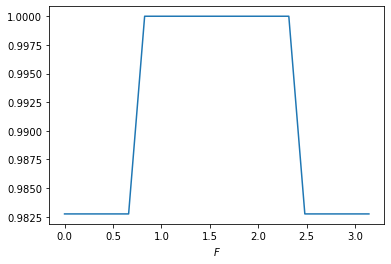

In [1]:
# Calculate match between a waveform and others

import sys
sys.path.insert(1,'../')
import EOBRun_module

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def modes_to_k(modes):
    """
    Map (l,m) -> k 
    """
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

def JBJF(hp,hc,dt):
    """
    Fourier transform of TD wfv
    """
    hptilde = np.fft.rfft(hp) * dt 
    hctilde = np.fft.rfft(-hc) * dt 
    return hptilde, hctilde
    
def match(hptilde1, hctilde1, hptilde2, hctilde2, dt, timeShift, frequencies, sigmasq):
    """
    Compute match
    """    
    # Antenna pattern        
    fp = 1
    fc = 0.    
    # Projection on the detector
    template = (fp*hptilde1+fc*hctilde1)*np.exp(-1j*2.0*np.pi*timeShift*frequencies)
    data = (fp*hptilde2+fc*hctilde2)
    # Match
    overlap = np.sum( (np.conj(data)*template+np.conj(template)*data)/sigmasq ).real
    norm1 = np.sum( 2*np.conj(template)*template/sigmasq ).real
    norm2 = np.sum( 2*np.conj(data)*data/sigmasq ).real
    Norma = np.sqrt( norm1*norm2 )
    return overlap/Norma

if __name__ == "__main__":

    verbose = 1 # print matches?

    # Generate the target waveform
    M1 = 36 # Mo
    M2 = 29 # Mo
    Deff = 410. # Mpc
    iota = np.pi/2.
    k = modes_to_k([[2,2]])# Use 22 mode only
    pars = {
        'M'                  : M1+M2,
        'q'                  : M1/M2,
        'Lambda1'            : 0.,
        'Lambda2'            : 0.,     
        'chi1'               : 0.,
        'chi2'               : 0.,
        'domain'             : 0,      # TD
        'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
        'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
        'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
        'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
        'interp_uniform_grid': 2,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
        'distance': Deff,
        'inclination':iota,
        
    }
    T, Hp, Hc = EOBRun_module.EOBRunPy(pars)
    Hptilde, Hctilde = JBJF(Hp,Hc,T[1]-T[0])

    # PSD
    # https://github.com/lscsoft/lalsuite-archive/blob/master/lalsimulation/src/LIGO-P1200087-v18-aLIGO_BNS_OPTIMIZED.txt
    f, psd  = np.loadtxt("./LIGO-P1200087-v18-aLIGO_BNS_OPTIMIZED.txt",unpack=True) # ASD
    psd *= psd

    # Generate an interpolant for the PSD
    psd_int =  interp1d(f, psd, bounds_error=False, fill_value=np.inf)

    # As an example, we vary the sky location 
    # and compute the match of the same source located at different positions
    iota_range = np.linspace(0,np.pi,20)
    
    # Compute the match 
    F = []
    for i in iota_range:

        # Compute new wvf
        pars['inclination'] = i
        t, hp, hc = EOBRun_module.EOBRunPy(pars)

        # Time shifts and normalisation of the Fourier transform                       
        dt              =  t[1]-t[0]
        n1              = len(Hp)
        n2              = len(hp)
        n               = np.minimum(n1,n2) 
        tc_index1 = np.argmax(Hp[:n]**2+Hc[:n]**2)       
        tc_1      = T[tc_index1]
        tc_index2 = np.argmax(hp[:n]**2+hc[:n]**2)       
        tc_2      = T[tc_index2]
        timeShift =(tc_2 - tc_1) # Arbitrary time shift
        frequencies = np.fft.rfftfreq(n,d=dt)
        sigmasq     =  psd_int(frequencies) * dt**2

        hptilde, hctilde = JBJF(hp,hc,t[1]-t[0])

        F.append( match(Hptilde, Hctilde,
                        hptilde, hctilde,
                        dt, timeShift, 
                        frequencies, sigmasq) )

        if (verbose): print(F[-1])

    # Plot
    plt.plot(iota_range, F, '')
    plt.xlabel(r'$\iota$')
    plt.xlabel(r'$F$')
    plt.show()
      
